# Exploratory Data Analysis
## Group SHINOBI: HONG-KOH-NOUV

This python notebook contents the information of the data analysis to help provide possible decisions for the next part such as modeling and applying feature engineering. We explored the given dataset of **scMARK** to understand its nature. 

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Model Building
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import balanced_accuracy_score
from problem import BalancedAccuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [3]:
X_train.shape

(1000, 13551)

In [10]:
X_train[:10].toarray()

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 2., 0., 0.]], dtype=float32)

In [5]:
y_train.shape

(1000,)

In [12]:
y_train[:10]

['T_cells_CD4+', 'T_cells_CD4+', 'T_cells_CD4+', 'T_cells_CD4+', 'T_cells_CD8+', 'T_cells_CD4+', 'Cancer_cells', 'Cancer_cells', 'NK_cells', 'T_cells_CD8+']
Categories (4, object): ['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']

### Class distribution

([0, 1, 2, 3],
 [Text(0, 0, 'Cancer_cells'),
  Text(1, 0, 'NK_cells'),
  Text(2, 0, 'T_cells_CD4+'),
  Text(3, 0, 'T_cells_CD8+')])

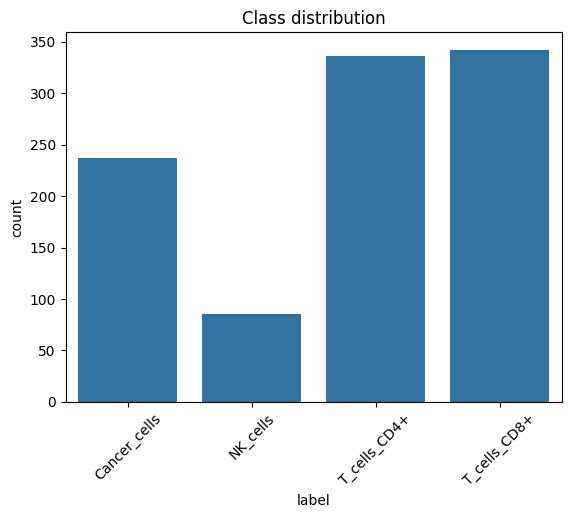

In [15]:
df_labels = pd.DataFrame({'label': y_train})
sns.countplot(data=df_labels, x='label')
plt.title("Class distribution")
plt.xticks(rotation=45)

This dataset seems to be unbalanced. The proportion of **NK_cells** is lower than other cells. This could mean we may get a good result on training dataset but not on tesing dataset. 

To improve, we have some ideas like using Oversampling the Minority Class (Random Oversampling or Synthetic Minority Over-sampling Technique) or using other technique depend on the performance or the adjustment (Still need a discussion after testing).

### Sparsity analysis

Because single-cell RNA-seq data is extremely sparse:
most values are zero.

Why? From what we see above:
- A cell expresses only some genes, not all 14,000
- Most genes are off in most cells
- So the matrix is full of zeros

For each cell, we compute percentage of genes that have expression equal to 0.

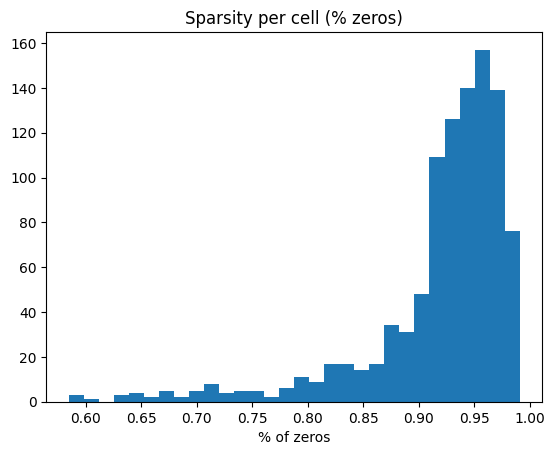

In [16]:
X_dense = X_train.toarray()

cell_zero_pct = (X_dense == 0).mean(axis=1)

plt.hist(cell_zero_pct, bins=30)
plt.title("Sparsity per cell (% zeros)")
plt.xlabel("% of zeros");

Most cells have 90–98 percent zeros. It means that:
- Each cell only expresses 2–10 percent of genes.
- This is normal, expected for scRNA-seq.[Macosko et al., 2018](https://www.nature.com/articles/s41467-017-02554-5)
- It also confirms that raw data is ultra sparse.

This also could mean:
- Sparse data = harder for models
- Many zeros = noise
- We need dimensionality reduction (PCA, HVG)
- We need normalization

For each gene, we compute percentage of cells where this gene is 0.

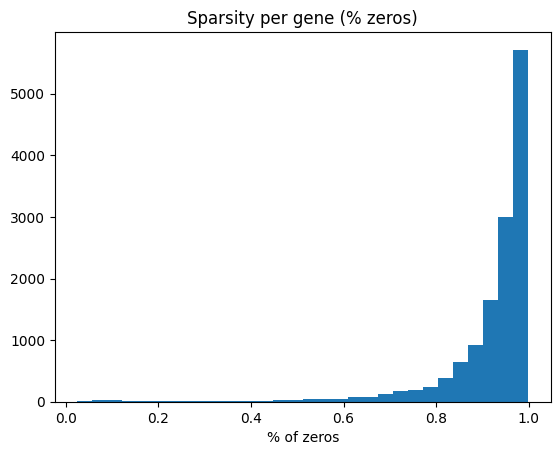

In [17]:
gene_zero_pct = (X_dense == 0).mean(axis=0)

plt.hist(gene_zero_pct, bins=30)
plt.title("Sparsity per gene (% zeros)")
plt.xlabel("% of zeros");

The majority of genes have 95–100 percent zeros which means:
- Most genes are expressed in almost no cells
- These genes carry little useful information for classification

Most genes do not vary enough; we should remove low-variance genes.

This is why scRNA workflows always include:
- Selecting Highly Variable Genes (HVG)
- Removing low-information genes
- Reducing the dimension from 14,000 → 2,000 or 500

### Gene variance analysis

Text(0, 0.5, 'Number of genes')

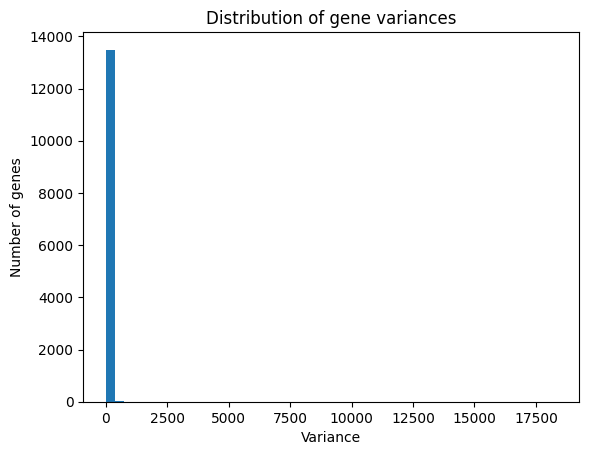

In [18]:
gene_variances = X_dense.var(axis=0)

plt.hist(gene_variances, bins=50)
plt.title("Distribution of gene variances")
plt.xlabel("Variance")
plt.ylabel("Number of genes")

In [19]:
(gene_variances < 1e-5).mean()

0.0

### Total expression per cell

Text(0, 0.5, 'Number of cells')

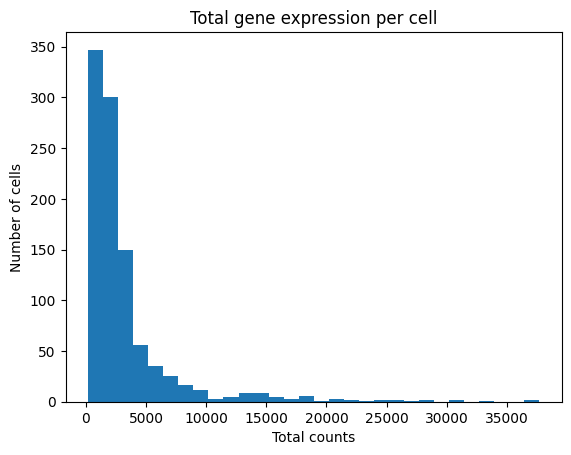

In [20]:
total_counts = X_dense.sum(axis=1)

plt.hist(total_counts, bins=30)
plt.title("Total gene expression per cell")
plt.xlabel("Total counts")
plt.ylabel("Number of cells")

### PCA for separability visualization

Text(0, 0.5, 'PC2')

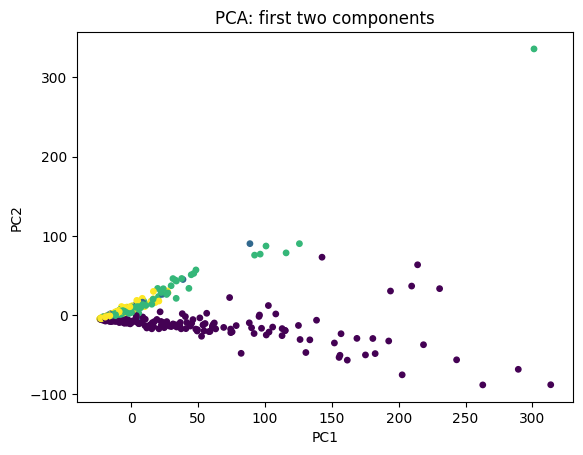

In [22]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X_dense)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train.codes, s=15)
plt.title("PCA: first two components")
plt.xlabel("PC1")
plt.ylabel("PC2")
